In [1]:
#!pip install matplotlib

# Domain Factuality Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from ast import literal_eval
df_urls = pd.read_pickle("../full_db.pkl")

df_urls = df_urls[~df_urls.sentiment_value.isna()]
df_urls = df_urls[df_urls.created_at < "2021-09-07"]

# df_urls["urls"]=df_urls.ent_urls.apply(lambda x: [y["expanded_url"] for y in literal_eval(x)])
df_urls["urls"]=df_urls.ent_urls.apply(lambda x: [y["expanded_url"] for y in x])

for row_idx, row in tqdm(df_urls.iterrows(), desc=f"global urls"):
    base_urls = []
    for url in row.urls:
        exp_url = url
        idx = exp_url.find("//")
        exp_url = exp_url[idx+2:]
        base_urls.append(exp_url.split("/")[0])
    df_urls.at[row_idx, "urls"] = base_urls

global urls: 129511it [00:15, 8138.76it/s]


In [4]:
# get all urls
df_rating = pd.read_csv("assets/iffi.csv")
df_rating.set_index("Domain",inplace=True)

def get_rating(url, rating):
    try:
        rating = df_rating.loc[url][rating]
    except:
        rating = "P"
    return rating


df_urls['url_rating'] = None
df_urls['url_factual'] = None
for idx, row in tqdm(df_urls.iterrows(), total=len(df_urls)):
    df_urls.at[idx, 'url_rating'] = [get_rating(url,'rating') for url in row.urls]
    df_urls.at[idx, 'url_factual'] = [get_rating(url,'factual') for url in row.urls]

new_df = {i:[] for i in ['tweet_id', 'url', 'rating', 'factual']}
for idx, row in tqdm(df_urls.iterrows(), total=len(df_urls)):
    for url, rating, factual in zip(row.urls,row.url_rating, row.url_factual):
        new_df['tweet_id'].append(row.tweet_id) 
        new_df['url'].append(url)
        new_df['rating'].append(rating)
        new_df['factual'].append(factual)

df = pd.DataFrame(new_df)





100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 129511/129511 [00:19<00:00, 6787.63it/s]


In [5]:
df.to_pickle("assets/tweets_url_rating.pkl")
df = pd.read_pickle("assets/tweets_url_rating.pkl")
df = df[df.url != 'twitter.com']

## Rating

In [6]:
positives = len(df[df.rating != "P"])
[f"{name:<30} {len(group):<10} {len(group)*100/positives:<10}" for name,group in df.groupby("rating")]

['P                              84271      4382.267290691628',
 'RC                             7          0.3640145605824233',
 'conspiracy-pseudoscience       874        45.44981799271971',
 'fake-news                      1021       53.094123764950595',
 'right                          2          0.10400416016640665',
 'unknown                        19         0.9880395215808633']

In [7]:
positives = len(df[df.rating != "P"])
[f"{name:<30} {len(group):<10} {len(group)*100/positives:<10}" for name,group in df.groupby("rating")]

['P                              84271      4382.267290691628',
 'RC                             7          0.3640145605824233',
 'conspiracy-pseudoscience       874        45.44981799271971',
 'fake-news                      1021       53.094123764950595',
 'right                          2          0.10400416016640665',
 'unknown                        19         0.9880395215808633']

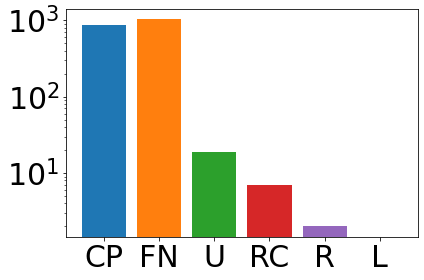

In [8]:
freqs = {n:len(group) for n,group in df.groupby('rating') if n != "P"}

classes = ['conspiracy-pseudoscience','fake-news','unknown',"RC","right","left"]
for c in classes:
    if c not in freqs:
        freqs[c]=0
        
plt.yscale("log")
plt.rcParams["figure.figsize"] = (8,8)

plt.bar(0,freqs['conspiracy-pseudoscience'])
plt.bar(1,freqs['fake-news'])
plt.bar(2,freqs['unknown'])
plt.bar(3,freqs['RC'])
plt.bar(4,freqs['right'])
plt.bar(5,freqs['left'])
    
plt.xticks(list(range(len(freqs.keys()))),["CP", "FN", "U", "RC", "R", "L"], fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig("output/plot_factuality_rating.pdf")
plt.show()

## Factuality

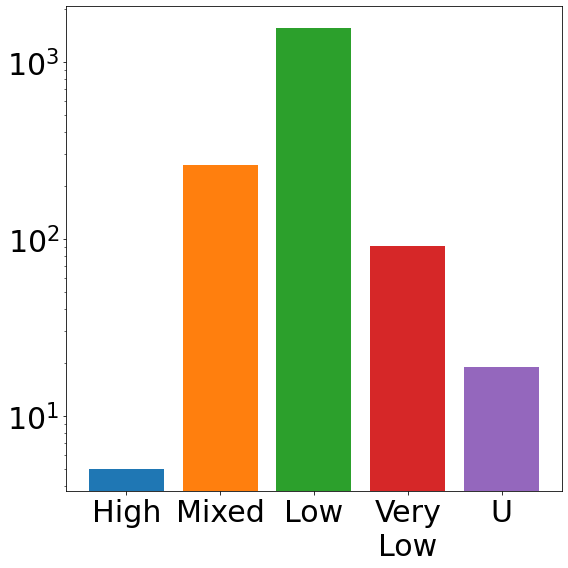

In [9]:
freqs = {n:len(group) for n,group in df.groupby('factual') if n != "P"}
freqs["low"] = freqs["left"]

classes = ['high','mixed','low',"very-low","unknown"]
for c in classes:
    if c not in freqs:
        freqs[c]=0

k_to_del = []
for k in freqs:
    if k not in classes:
        k_to_del.append(k)
for k in k_to_del:
    del freqs[k]
        
plt.yscale("log")
plt.rcParams["figure.figsize"] = (8,8)

plt.bar(0,freqs['high'])
plt.bar(1,freqs['mixed'])
plt.bar(2,freqs['low'])
plt.bar(3,freqs['very-low'])
plt.bar(4,freqs['unknown'])
    
plt.xticks(list(range(len(freqs.keys()))),["High", "Mixed", "Low", "Very\nLow", "U"], fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig("output/plot_factuality_fact_level.pdf")
plt.show()

## Positive

In [10]:
df_positive = df[df.factual == "P"]
tot = len(df_positive)
freqs = [(len(group), name, len(group)*100/tot) for name,group in df_positive.groupby('url')]

sorted(freqs,reverse=True)[:10]

[(3414, 'bit.ly', 4.051215720710565),
 (2423, 'www.theguardian.com', 2.875247712736291),
 (2300, 'www.reuters.com', 2.729290028598213),
 (1952, 'www.nytimes.com', 2.316336580792918),
 (1806, 'www.abc.net.au', 2.1430859963688578),
 (1743, 'www.cnbc.com', 2.068327182542037),
 (959, 'www.dailymail.co.uk', 1.1379952771416026),
 (954, 'dlvr.it', 1.1320620379489978),
 (948, 'www.google.com', 1.124942150917872),
 (947, 'www.fda.gov', 1.1237555030793511)]

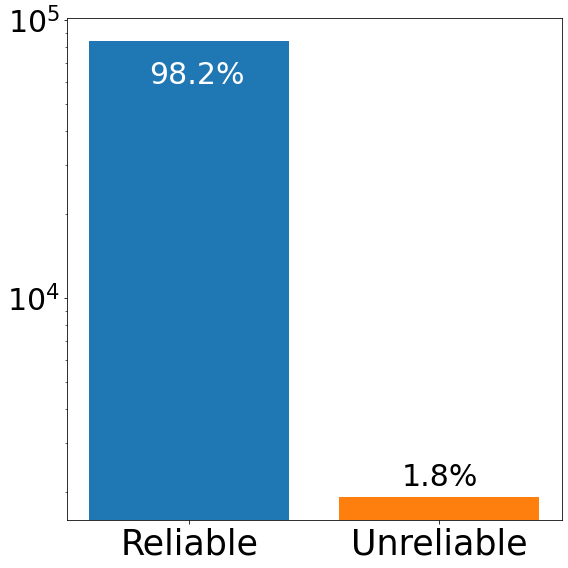

In [11]:
pos = df[df.factual == "P"]
neg = df[df.factual != "P"]

plt.yscale("log")
plt.rcParams["figure.figsize"] = (8,8)

plt.bar(0, len(pos), label="Positive")
plt.bar(1, len(neg), label="Negative")
plt.text(x=-0.16,y=len(pos)-(len(pos)*0.3),s="98.2%", fontsize=30, color="w")
plt.text(x=0.85,y=len(neg)+(len(neg)*0.1),s="1.8%", fontsize=30, color="k")
    
plt.xticks([0,1], ["Reliable","Unreliable"], fontsize=35)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig("output/plot_reliable_vs_unreliable.pdf")
plt.show()